<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/Pytorch_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

통계학과 2029007학번 김민정

In [1]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [2]:
import ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

import statsmodels.api as sm



#1 Simple Linear Regression using Boston data

In [ ]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [ ]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
y = Boston['medv']
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [ ]:
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

Now we do standardization on lstat in X matrix.

In [ ]:
lstat_mean = np.mean(X["lstat"])
lstat_std = np.std(X["lstat"])
X["lstat"] = ( X["lstat"]- lstat_mean) / lstat_std
X

,intercept,lstat
0,1.0,-1.075562
1,1.0,-0.492439
2,1.0,-1.208727
3,1.0,-1.361517
4,1.0,-1.026501
...,...,...
501,1.0,-0.418147
502,1.0,-0.500850
503,1.0,-0.983048
504,1.0,-0.865302


Equivalently, you can use the following code to create the design matrix `X`.

```
lstat = np.array(Boston["lstat"])
lstat = (lstat-np.mean(lstat))/np.std(lstat)
print(Boston.shape)
n = Boston.shape[0]
ones = np.ones([n])
X = np.stack([ones, lstat], axis=1 )
y = Boston['medv']
```

In [ ]:
model = sm.OLS(y, X)
results = model.fit()

In [ ]:
summarize(results)

,coef,std err,t,P>|t|
intercept,22.5328,0.276,81.545,0.0
lstat,-6.7777,0.276,-24.528,0.0


In [ ]:
new_predictions = results.get_prediction(X)

In [ ]:
yhat = new_predictions.predicted_mean
yhat.shape

(506,)

In [ ]:
np.mean((y-yhat)**2)

38.48296722989415

In [ ]:
np.mean((y-np.mean(y))**2)

84.41955615616556

# Exercise 1.1:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=True)`. Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

ii. Calculate $R^2$.

iii. Calculate AIC.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

In [3]:
import torch
import torch.optim

from torch.utils.data import Dataset, TensorDataset, DataLoader

In [ ]:
# X의 데이터 타입 확인
X["lstat"].dtype

dtype('float64')

In [ ]:
# y의 데이터 타입 확인
y.dtype

dtype('float64')

- 32비트 숫자와 64비트는 곱해지지 않기 때문에 dtype을 알맞게 바꿔줘야 한다.
- 알맞은 연산을 위해서 올바르게 broacasting을 해줘야 한다. X와 Y 모두 [n,1] shape으로 만들어주자.
- 사용할 model의 w shape이 [1,1]이기 때문에 X의 shape은 [n,1]이어야 한다.

In [ ]:
# X(표준화됨),Y 데이터 정의 (X: myX, Y: myY)
myX = torch.tensor(X["lstat"], dtype=torch.float32).reshape(-1,1)
myY = torch.tensor(y, dtype=torch.float32).reshape(-1,1)

In [ ]:
# X가 올바르게 정의되었는지 확인을 위해 5개만 확인
myX[:5,]

tensor([[-1.0756],
        [-0.4924],
        [-1.2087],
        [-1.3615],
        [-1.0265]])

In [ ]:
# Y가 올바르게 정의되었는지 확인을 위해 5개만 확인
myY[:5,]

tensor([[24.0000],
        [21.6000],
        [34.7000],
        [33.4000],
        [36.2000]])

- 배치 사이즈는 5로 해주었다.

In [ ]:
# SGD를 위한 데이터 정의
dataset = TensorDataset(myX, myY)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# 모델 정의
model = torch.nn.Linear(1,1,bias=True)

# loss function 정의
def loss_ftn(yhat,y):
  return torch.mean((yhat-y)**2)

epochs = 100
history = []

# optimizer 정의 (weight, bias)
my_optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# SGD
for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yhat, yy)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(myY))

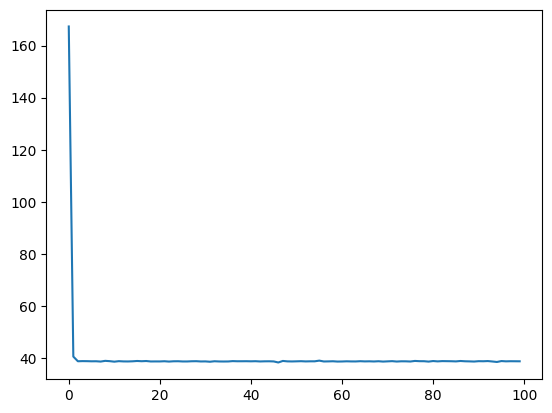

In [ ]:
# loss
import matplotlib.pyplot as plt
plt.plot(history)

- 정규화된 x를 사용하여 모델을 만들었기 때문에, yhat을 구할 때 x 역시 정규화 해주어야 한다.
- 모델을 사용하여 yhat을 구하기 위해선 데이터 타입을 float32로 바꾸어야 한다.

In [ ]:
# x 정규화
x5 = torch.tensor([[(5-lstat_mean)/lstat_std]], dtype=torch.float32)
x10 = torch.tensor([[(10-lstat_mean)/lstat_std]], dtype=torch.float32)
x15 = torch.tensor([[(15-lstat_mean)/lstat_std]], dtype=torch.float32)

# yhat
print(model(x5).data) # x = 5일때
print(model(x10).data) # x = 10일때
print(model(x15).data) # x = 15일때

tensor([[29.4326]])
tensor([[24.8256]])
tensor([[20.2185]])


ii. Calculate $R^2$.

In [ ]:
# R-squared 계산 함수 정의
def R2(y, yhat):
  SSE = torch.sum((y-yhat)**2)
  SST = torch.sum((y-torch.mean(y))**2)
  return 1 - SSE/SST

In [ ]:
# y: myY, yhat: model(myX)
R2(myY, model(myX))

tensor(0.5436, grad_fn=<RsubBackward1>)

iii. Calculate AIC.

# Exercise 1.2:

Do the estimatsion procedure using `torch.nn.Linear(2,1, bias=False)`.Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

ii. Calculate $R^2$.

iii. Calculate AIC.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

- model weight의 shape이 [2,1]이고 bias=False이므로 X의 shape은 [n,2]이어야 한다.
- X의 구조는 1열은 전부 1로 구성되고, 2열에 데이터가 위치한다.

In [ ]:
# 표준화된 X
X

,intercept,lstat
0,1.0,-1.075562
1,1.0,-0.492439
2,1.0,-1.208727
3,1.0,-1.361517
4,1.0,-1.026501
...,...,...
501,1.0,-0.418147
502,1.0,-0.500850
503,1.0,-0.983048
504,1.0,-0.865302


In [ ]:
# 데이터 타입 변경 (float32로)
myX = torch.tensor(X.values, dtype=torch.float32)
myY = torch.tensor(y, dtype=torch.float32).reshape(-1,1) # Y shape [n,1]로

In [ ]:
# 데이터 일부분 확인
myX[:5,]

tensor([[ 1.0000, -1.0756],
        [ 1.0000, -0.4924],
        [ 1.0000, -1.2087],
        [ 1.0000, -1.3615],
        [ 1.0000, -1.0265]])

In [ ]:
# 데이터 일부분 확인
myY[:5,]

tensor([[24.0000],
        [21.6000],
        [34.7000],
        [33.4000],
        [36.2000]])

In [ ]:
# SGD를 위한 데이터 정의
dataset = TensorDataset(myX,myY)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# SGD
model = torch.nn.Linear(2,1, bias=False)

def loss_ftn(yhat,y):
  return torch.mean((yhat-y)**2)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yhat,yy)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(myY))

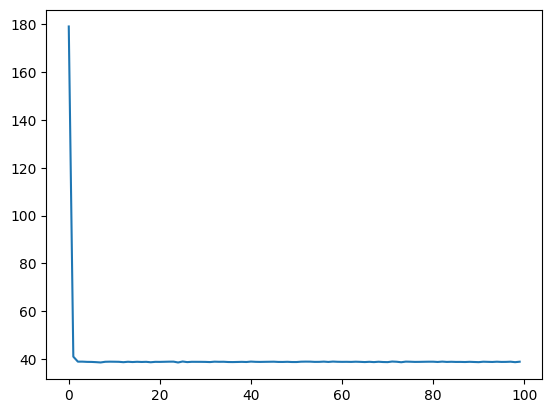

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history)

- x의 shape은 [1,2] 이어야 한다. 1열에는 1이 위치한다.

In [ ]:
# x 정규화
x5 = torch.tensor([[1, (5-lstat_mean)/lstat_std]], dtype=torch.float32)
x10 = torch.tensor([[1, (10-lstat_mean)/lstat_std]], dtype=torch.float32)
x15 = torch.tensor([[1, (15-lstat_mean)/lstat_std]], dtype=torch.float32)

# yhat
print(model(x5).data) # x = 5일때
print(model(x10).data) # x = 10일때
print(model(x15).data) # x = 15일때

tensor([[29.0230]])
tensor([[24.8830]])
tensor([[20.7431]])


ii. Calculate $R^2$.

In [ ]:
# R-squared 계산 함수 정의
def R2(y, yhat):
  SSE = torch.sum((y-yhat)**2)
  SST = torch.sum((y-torch.mean(y))**2)
  return 1 - SSE/SST

In [ ]:
# y: myY, yhat: model(myX)
R2(myY, model(myX))

tensor(0.5349, grad_fn=<RsubBackward1>)

iii. Calculate AIC.

# Exercise 1.3:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=False)` and an additional bias parameter defined by `torch.tensor`. Model itself should be the same as in Exercise 1.1 and 1.2. (Caution: However, the estimated parameter(s) should not be the exactly the same due to the randomness in the parameter initialization and batch learning.)

Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

ii. Calculate $R^2$.

iii. Calculate AIC.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

- X의 shape은 [n,1]이어야 한다.

In [ ]:
# 데이터 타입 변경 (float32로)
myX = torch.tensor(X["lstat"], dtype=torch.float32).reshape(-1,1) # X shape [n,1]
myY = torch.tensor(y, dtype=torch.float32).reshape(-1,1) # Y shape [n,1]

In [ ]:
# X 데이터 일부분 확인
myX[:5,]

tensor([[-1.0756],
        [-0.4924],
        [-1.2087],
        [-1.3615],
        [-1.0265]])

In [ ]:
# Y 데이터 일부분 확인
myY[:5,]

tensor([[24.0000],
        [21.6000],
        [34.7000],
        [33.4000],
        [36.2000]])

In [ ]:
# SGD를 위한 데이터 정의
dataset = TensorDataset(myX,myY)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# SGD
model = torch.nn.Linear(1,1, bias=False)
bias = torch.tensor([torch.randn([1])], requires_grad=True)

def loss_ftn(yhat,y):
  return torch.mean((yhat-y)**2)

epochs = 100
history = []

# 리스트 + 리스트를 하면 두 개의 리스트가 붙여진다.
my_optimizer = torch.optim.SGD(list(model.parameters()) + [bias], lr = 0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx) + bias # bias를 더해주어야 한다.
    loss = loss_ftn(yhat,yy)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(myY))

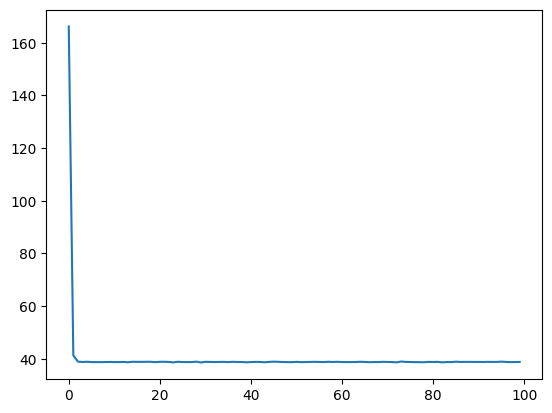

In [ ]:
# loss graph
plt.plot(history)

In [ ]:
# x 정규화
x5 = torch.tensor([[(5-lstat_mean)/lstat_std]], dtype=torch.float32)
x10 = torch.tensor([[(10-lstat_mean)/lstat_std]], dtype=torch.float32)
x15 = torch.tensor([[(15-lstat_mean)/lstat_std]], dtype=torch.float32)

# yhat
print(model(x5).data + bias.data) # x = 5일때
print(model(x10).data + bias.data) # x = 10일때
print(model(x15).data+ bias.data) # x = 15일때

tensor([[29.8865]])
tensor([[25.0798]])
tensor([[20.2731]])


ii. Calculate $R^2$.

In [ ]:
# R-squared 계산 함수 정의
def R2(y, yhat):
  SSE = torch.sum((y-yhat)**2)
  SST = torch.sum((y-torch.mean(y))**2)
  return 1 - SSE/SST

In [ ]:
# y: myY, yhat: model(myX) + bias
R2(myY, model(myX) + bias)

tensor(0.5441, grad_fn=<RsubBackward1>)

iii. Calculate AIC.

#2. Multiple regression

In [ ]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [ ]:
design = MS(['lstat', "age"])
X = design.fit_transform(Boston)
y = Boston['medv']
X

,intercept,lstat,age
0,1.0,4.98,65.2
1,1.0,9.14,78.9
2,1.0,4.03,61.1
3,1.0,2.94,45.8
4,1.0,5.33,54.2
...,...,...,...
501,1.0,9.67,69.1
502,1.0,9.08,76.7
503,1.0,5.64,91.0
504,1.0,6.48,89.3


Now we do standardization on lstat in X matrix.

In [ ]:
lstat_mean = np.mean(X["lstat"])
lstat_std = np.std(X["lstat"])
age_mean = np.mean(X["age"])
age_std = np.std(X["age"])

X["lstat"] = ( X["lstat"]- lstat_mean) / lstat_std
X["age"] = ( X["age"]- age_mean) / age_std

In [ ]:
X

,intercept,lstat,age
0,1.0,-1.075562,-0.120013
1,1.0,-0.492439,0.367166
2,1.0,-1.208727,-0.265812
3,1.0,-1.361517,-0.809889
4,1.0,-1.026501,-0.511180
...,...,...,...
501,1.0,-0.418147,0.018673
502,1.0,-0.500850,0.288933
503,1.0,-0.983048,0.797449
504,1.0,-0.865302,0.736996


In [ ]:
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

The same design matrix `X` can be obtained from the following code.

```
lstat = np.array(Boston["lstat"])
lstat = (lstat-np.mean(lstat))/np.std(lstat)

age = np.array(Boston["age"])
age = (lstat-np.mean(age))/np.std(age)

X = np.stack([ones, lstat, age], axis=1)
X.shape
X
```

In [ ]:
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,22.5328,0.274,82.108,0.000
lstat,-7.3628,0.344,-21.416,0.000
age,0.9714,0.344,2.826,0.005


## 2.1 Exercise:

Using the standardizied `Boston` data answer the following questions.

(a) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat`

(b) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat + lstat**2`

(c) Using pytorch and customized layer, calculate $R^2$ of each model in (a) and (b).

(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.


In [4]:
import torch
import torch.optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

데이터 정의 : (myX, myY)

In [ ]:
myX_a = torch.tensor(X.values, dtype=torch.float32) # dtype을 32비트로
myY = torch.tensor(y, dtype=torch.float32).reshape(-1,1) # Y shape은 [n,1]

In [ ]:
myX_a

tensor([[ 1.0000, -1.0756, -0.1200],
        [ 1.0000, -0.4924,  0.3672],
        [ 1.0000, -1.2087, -0.2658],
        ...,
        [ 1.0000, -0.9830,  0.7974],
        [ 1.0000, -0.8653,  0.7370],
        [ 1.0000, -0.6691,  0.4347]])

In [ ]:
myY

tensor([[24.0000],
        [21.6000],
        [34.7000],
        [33.4000],
        [36.2000],
        [28.7000],
        [22.9000],
        [27.1000],
        [16.5000],
        [18.9000],
        [15.0000],
        [18.9000],
        [21.7000],
        [20.4000],
        [18.2000],
        [19.9000],
        [23.1000],
        [17.5000],
        [20.2000],
        [18.2000],
        [13.6000],
        [19.6000],
        [15.2000],
        [14.5000],
        [15.6000],
        [13.9000],
        [16.6000],
        [14.8000],
        [18.4000],
        [21.0000],
        [12.7000],
        [14.5000],
        [13.2000],
        [13.1000],
        [13.5000],
        [18.9000],
        [20.0000],
        [21.0000],
        [24.7000],
        [30.8000],
        [34.9000],
        [26.6000],
        [25.3000],
        [24.7000],
        [21.2000],
        [19.3000],
        [20.0000],
        [16.6000],
        [14.4000],
        [19.4000],
        [19.7000],
        [20.5000],
        [25.

(a)

In [ ]:
# SGD에 사용할 데이터 정의
dataset = TensorDataset(myX_a, myY)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# customed layer (model을 정의 및 yhat 계산)
class MyLinear_a(torch.nn.Module):
  def __init__(self, in_units, units):
    super().__init__()
    self.weight = torch.nn.Parameter(torch.randn(in_units, units))

  def forward(self,X):
    return X @ self.weight

In [ ]:
# model 정의
model_a = MyLinear_a(3,1)

# MSE 계산 함수 정의
def MSE(y,yhat):
  return torch.mean((y-yhat)**2)

epochs = 100
history = []

# optimizer 정의
my_optimizer = torch.optim.SGD(model_a.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model_a(xx)
    loss = MSE(yy,yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(myY))

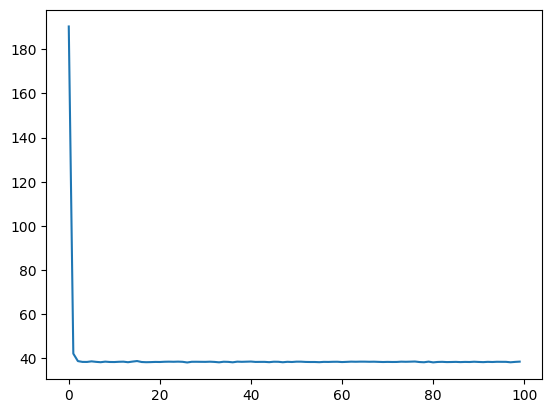

In [ ]:
# MSE graph
import matplotlib.pyplot as plt
plt.plot(history)

In [ ]:
# train MSE
Yhat_a = model_a(myX_a)
MSE(myY, Yhat_a)

tensor(37.8982, grad_fn=<MeanBackward0>)

(b)

In [ ]:
# X 원본 (표준화 안 됨)
design = MS(['lstat', "age"])
X = design.fit_transform(Boston)
X

,intercept,lstat,age
0,1.0,4.98,65.2
1,1.0,9.14,78.9
2,1.0,4.03,61.1
3,1.0,2.94,45.8
4,1.0,5.33,54.2
...,...,...,...
501,1.0,9.67,69.1
502,1.0,9.08,76.7
503,1.0,5.64,91.0
504,1.0,6.48,89.3


In [ ]:
import numpy as np

In [ ]:
Ones = torch.tensor(X.shape[0])
X1 = X['age']
X2 = X['lstat']
X3 = X['lstat']**2

# 표준화
age_mean = np.mean(X1)
age_std = np.std(X1)
lstat_mean = np.mean(X2)
lstat_std = np.std(X2)
lstat2_mean = np.mean(X3)
lstat2_std = np.std(X3)

X1 = torch.tensor((X1-age_mean)/age_std, dtype=torch.float32)
X2 = torch.tensor((X2-lstat_mean)/lstat_std, dtype=torch.float32)
X3 = torch.tensor((X3-lstat2_mean)/lstat2_std, dtype=torch.float32)

# X 데이터 정의
Ones = torch.ones(X1.shape[0])
myX_b = torch.stack([Ones, X1,X2,X3], axis=1)
myX_b

tensor([[ 1.0000, -0.1200, -1.0756, -0.7895],
        [ 1.0000,  0.3672, -0.4924, -0.5405],
        [ 1.0000, -0.2658, -1.2087, -0.8258],
        ...,
        [ 1.0000,  0.7974, -0.9830, -0.7598],
        [ 1.0000,  0.7370, -0.8653, -0.7166],
        [ 1.0000,  0.4347, -0.6691, -0.6314]])

- 1열: 1벡터
- 2열: 표준화된 age
- 3열: 표준화된 lstat
- 4열: 표준화된 lstat**2

In [ ]:
# SGD에 사용할 데이터 정의
dataset = TensorDataset(myX_b, myY)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# customized layer
class MyLinear_b(torch.nn.Module):
  def __init__(self, in_units, units):
    super().__init__()
    self.weight = torch.nn.Parameter(torch.randn(in_units, units))

  def forward(self,X):
    return X @ self.weight

In [ ]:
# SGD
model_b = MyLinear_b(4,1)

def MSE(y,yhat):
  return torch.mean((y-yhat)**2)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model_b.parameters(), lr = 0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model_b(xx)
    loss = MSE(yy, yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(myY))

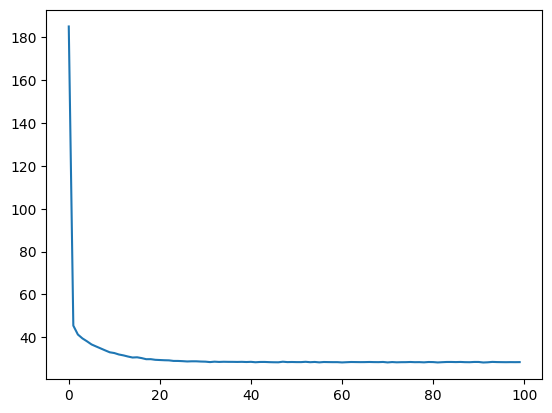

In [ ]:
# MSE graph
plt.plot(history)

In [ ]:
# train MSE
Yhat_b = model_b(myX_b)
MSE(myY, Yhat_b)

tensor(28.0721, grad_fn=<MeanBackward0>)

(c)

In [ ]:
# R-squared 계산 함수 정의
def R2(y,yhat):
  SSR = torch.sum((y-yhat)**2)
  SST = torch.sum((y-torch.mean(y))**2)
  return 1 - SSR/SST

In [ ]:
# model(a)의 R2
Yhat_a = model_a(myX_a)
R2(myY, Yhat_a)

tensor(0.5511, grad_fn=<RsubBackward1>)

In [ ]:
# model(b)의 R2
Yhat_b = model_b(myX_b)
R2(myY, Yhat_b)

tensor(0.6675, grad_fn=<RsubBackward1>)

(d)

> model A

In [ ]:
# 데이터셋을 train data : test data = 7:3으로 분할
dataset = TensorDataset(myX_a,myY)

n = len(myY)

train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])

trainloader = DataLoader( dataset = train_set, batch_size = 5, shuffle = True)
testloader =  DataLoader( dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
# model 정의
model_d1 = MyLinear_a(3,1)

epochs = 100
history = []

# optimizer 정의
my_optimizer = torch.optim.SGD(model_d1.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  N = 0 # train data의 개수
  for xx, yy in trainloader:
    yhat = model_d1(xx)
    loss = MSE(yy,yhat)
    LOSS_sum += loss * len(yy)
    N += len(yy) # yy 개수를 계속 더해주어 최종적으로 train data의 개수를 얻는다.
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/N)

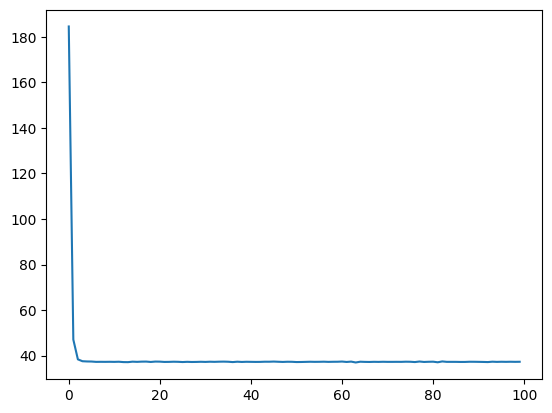

In [ ]:
plt.plot(history)

MSE 구하기

In [ ]:
# X_train (train set의 X)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train X들이 들어있는 list가 된다.)
X_train = torch.tensor(temp2).reshape(-1,3) # tensor로 변경하고 [n,3] shape으로 변경한다.

# y_train (train set의 y)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train Y들이 들어있는 list가 된다.)
y_train = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [ ]:
print(X_train[:5])
print(y_train[:5])

tensor([[ 1.0000, -1.0335, -1.6882],
        [ 1.0000, -0.1785, -0.5076],
        [ 1.0000, -0.8541, -1.8163],
        [ 1.0000,  1.9606,  0.7299],
        [ 1.0000, -1.0924, -1.8091]])
tensor([[25.0000],
        [22.0000],
        [26.2000],
        [10.4000],
        [33.1000]])


In [ ]:
# X_test (test set의 X)
temp2 = []
for xx, yy in val_set: # val_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 test X들이 들어있는 list가 된다.)
X_test = torch.tensor(temp2).reshape(-1,3) # tensor로 변경하고 [n,3] shape으로 변경한다.

# y_test (test set의 y)
temp2 = []
for xx, yy in val_set: # val_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 test Y들이 들어있는 list가 된다.)
y_test = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [ ]:
print(X_test[:5])
print(y_test[:5])

tensor([[ 1.0000,  0.1650,  0.7334],
        [ 1.0000, -0.6887,  0.2249],
        [ 1.0000, -0.7756,  0.6872],
        [ 1.0000,  0.2407,  0.0400],
        [ 1.0000, -0.9354, -0.5610]])
tensor([[19.6000],
        [23.7000],
        [27.5000],
        [22.0000],
        [22.1000]])


In [ ]:
# train MSE
y_train_hat_a = model_a(X_train)
MSE(y_train_hat_a, y_train)

tensor(36.8885, grad_fn=<MeanBackward0>)

In [ ]:
# test MSE
y_test_hat_a = model_a(X_test)
MSE(y_test_hat_a, y_test)

tensor(40.4127, grad_fn=<MeanBackward0>)

> model B

In [ ]:
# 데이터셋을 train data : test data = 7:3으로 분할
dataset = TensorDataset(myX_b,myY)

n = len(myY)

train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])

trainloader = DataLoader( dataset = train_set, batch_size = 5, shuffle = True)
testloader =  DataLoader( dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [ ]:
# model 정의
model_d2 = MyLinear_b(4,1) # 이번엔 beta가 총 4개이다.

epochs = 100
history = []

# optimizer 정의
my_optimizer = torch.optim.SGD(model_d2.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  N = 0 # train data의 개수
  for xx, yy in trainloader:
    yhat = model_d2(xx)
    loss = MSE(yy,yhat)
    LOSS_sum += loss * len(yy)
    N += len(yy) # yy 개수를 계속 더해주어 최종적으로 train data의 개수를 얻는다.
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/N)

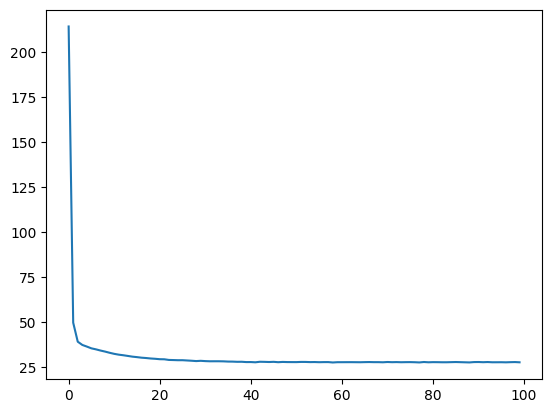

In [ ]:
# MSE graph
plt.plot(history)

MSE 구하기

In [ ]:
# X_train (train set의 X)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train X들이 들어있는 list가 된다.)
X_train = torch.tensor(temp2).reshape(-1,4) # tensor로 변경하고 [n,4] shape으로 변경한다.

# y_train (train set의 y)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train Y들이 들어있는 list가 된다.)
y_train = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [ ]:
print(X_train[:5])
print(y_train[:5])

tensor([[ 1.0000,  1.1175,  2.5143,  3.0732],
        [ 1.0000, -1.8340, -1.2241, -0.8295],
        [ 1.0000,  0.3245, -0.1616, -0.3339],
        [ 1.0000, -0.0560, -0.7307, -0.6600],
        [ 1.0000, -1.2224, -1.3377, -0.8537]])
tensor([[ 5.0000],
        [46.7000],
        [16.2000],
        [50.0000],
        [44.0000]])


In [ ]:
# X_test (test set의 X)
temp2 = []
for xx, yy in val_set: # val_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 test X들이 들어있는 list가 된다.)
X_test = torch.tensor(temp2).reshape(-1,4) # tensor로 변경하고 [n,4] shape으로 변경한다.

# y_test (test set의 y)
temp2 = []
for xx, yy in val_set: # val_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 test Y들이 들어있는 list가 된다.)
y_test = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [ ]:
print(X_test[:5])
print(y_test[:5])

tensor([[ 1.0000, -0.5681, -1.3307, -0.8523],
        [ 1.0000,  0.8152, -0.9452, -0.7466],
        [ 1.0000,  1.1175, -0.7377, -0.6631],
        [ 1.0000,  0.3778, -0.3509, -0.4578],
        [ 1.0000,  0.7121,  1.5877,  1.5437]])
tensor([[43.5000],
        [48.8000],
        [23.3000],
        [20.5000],
        [19.3000]])


In [ ]:
# train MSE
y_train_hat_b = model_b(X_train)
MSE(y_train_hat_b, y_train)

tensor(27.6306, grad_fn=<MeanBackward0>)

In [ ]:
# test MSE
y_test_hat_b = model_b(X_test)
MSE(y_test_hat_b, y_test)

tensor(29.1005, grad_fn=<MeanBackward0>)

In [ ]:
# test MSE (testloader에 저장된 데이터를 이용하는 방법)
for x, y in testloader:
  yhat = model_b(x)

MSE(yhat, y)

tensor(29.1005, grad_fn=<MeanBackward0>)

#3. Qualitative predictors

In [5]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [6]:
Carseats.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [7]:
my_vars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
X = MS(["Advertising", "ShelveLoc"]).fit_transform(Carseats)
X

,intercept,Advertising,ShelveLoc[Good],ShelveLoc[Medium]
0,1.0,11,0.0,0.0
1,1.0,16,1.0,0.0
2,1.0,10,0.0,1.0
3,1.0,4,0.0,1.0
4,1.0,3,0.0,0.0
...,...,...,...,...
395,1.0,17,1.0,0.0
396,1.0,3,0.0,1.0
397,1.0,12,0.0,1.0
398,1.0,7,0.0,0.0


In [8]:
adv_mean = np.mean(X["Advertising"])
adv_std = np.std(X["Advertising"])

X["Advertising"] = ( X["Advertising"]- adv_mean) / adv_std


In [9]:
X

,intercept,Advertising,ShelveLoc[Good],ShelveLoc[Medium]
0,1.0,0.657177,0.0,0.0
1,1.0,1.409957,1.0,0.0
2,1.0,0.506621,0.0,1.0
3,1.0,-0.396715,0.0,1.0
4,1.0,-0.547271,0.0,0.0
...,...,...,...,...
395,1.0,1.560513,1.0,0.0
396,1.0,-0.547271,0.0,1.0
397,1.0,0.807733,0.0,1.0
398,1.0,0.054953,0.0,0.0


The similar design matrix can be obtained from the following code:

```
ones = np.ones(Carseats.shape[0])
X = np.stack([ones, Carseats["Advertising"], Carseats["ShelveLoc"]], axis=1)
X.shape
X

my_dummy = pd.get_dummies(Carseats.ShelveLoc)
my_dummy

X = np.stack([ones, Carseats["Advertising"], my_dummy["Bad"], my_dummy["Good"]], axis=1)
X.shape
X

```

In [ ]:

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,5.5648,0.229,24.284,0.0
Advertising,0.6689,0.112,5.951,0.0
ShelveLoc[Good],4.5769,0.335,13.671,0.0
ShelveLoc[Medium],1.7514,0.275,6.375,0.0


## 3.1 Exercise:

Using `Carseats` data answer the following questions.

(a) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising + ShelveLoc`

(b) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising`

(c) Calculate $R^2$ of each model in (a) and (b).

(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.

(a)

In [12]:
X

,intercept,Advertising,ShelveLoc[Good],ShelveLoc[Medium]
0,1.0,0.657177,0.0,0.0
1,1.0,1.409957,1.0,0.0
2,1.0,0.506621,0.0,1.0
3,1.0,-0.396715,0.0,1.0
4,1.0,-0.547271,0.0,0.0
...,...,...,...,...
395,1.0,1.560513,1.0,0.0
396,1.0,-0.547271,0.0,1.0
397,1.0,0.807733,0.0,1.0
398,1.0,0.054953,0.0,0.0


In [13]:
y

0       9.50
1      11.22
2      10.06
3       7.40
4       4.15
       ...  
395    12.57
396     6.14
397     7.41
398     5.94
399     9.71
Name: Sales, Length: 400, dtype: float64

In [17]:
# X 정의
x1 = torch.tensor(X['Advertising'], dtype=torch.float32)
x2 = torch.tensor(X['ShelveLoc[Good]'], dtype=torch.float32)
x3 = torch.tensor(X['ShelveLoc[Medium]'], dtype=torch.float32)

X_3a = torch.stack([x1,x2,x3], axis=1)
X_3a

tensor([[ 0.6572,  0.0000,  0.0000],
        [ 1.4100,  1.0000,  0.0000],
        [ 0.5066,  0.0000,  1.0000],
        ...,
        [ 0.8077,  0.0000,  1.0000],
        [ 0.0550,  0.0000,  0.0000],
        [-0.9989,  1.0000,  0.0000]])

In [108]:
# y 정의 ([n,1] shape)
y = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
y

tensor([[ 9.5000],
        [11.2200],
        [10.0600],
        [ 7.4000],
        [ 4.1500],
        [10.8100],
        [ 6.6300],
        [11.8500],
        [ 6.5400],
        [ 4.6900],
        [ 9.0100],
        [11.9600],
        [ 3.9800],
        [10.9600],
        [11.1700],
        [ 8.7100],
        [ 7.5800],
        [12.2900],
        [13.9100],
        [ 8.7300],
        [ 6.4100],
        [12.1300],
        [ 5.0800],
        [ 5.8700],
        [10.1400],
        [14.9000],
        [ 8.3300],
        [ 5.2700],
        [ 2.9900],
        [ 7.8100],
        [13.5500],
        [ 8.2500],
        [ 6.2000],
        [ 8.7700],
        [ 2.6700],
        [11.0700],
        [ 8.8900],
        [ 4.9500],
        [ 6.5900],
        [ 3.2400],
        [ 2.0700],
        [ 7.9600],
        [10.4300],
        [ 4.1200],
        [ 4.1600],
        [ 4.5600],
        [12.4400],
        [ 4.3800],
        [ 3.9100],
        [10.6100],
        [ 1.4200],
        [ 4.4200],
        [ 7.

In [45]:
# SGD에 사용할 데이터 정의
dataset = TensorDataset(X_3a, y)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [46]:
model = torch.nn.Linear(3,1,bias=True)

def loss_ftn(y,yhat):
  return torch.mean((y-yhat)**2)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yy, yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(y))

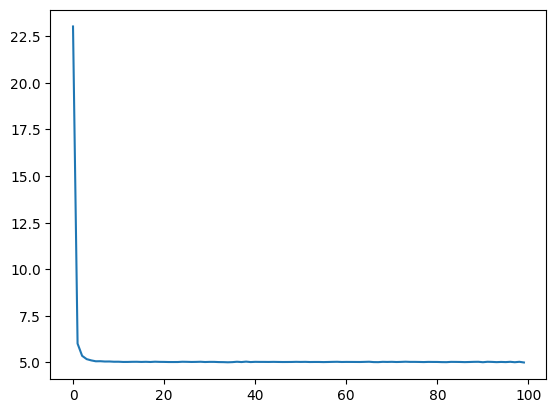

In [47]:
import matplotlib.pyplot as plt
plt.plot(history)

In [48]:
# train MSE
yhat_a = model(X_3a)
MSE = torch.mean((y-yhat_a)**2)
print(MSE)

tensor(5.0056, grad_fn=<MeanBackward0>)


(b)

In [35]:
# X(Advertising) 정의
# 앞에서 advertising 값을 x1에 할당해주었음. 이를 사용하자
X_3b = x1.reshape(-1,1) # [n,1] shape
X_3b[:5]

tensor([[ 0.6572],
        [ 1.4100],
        [ 0.5066],
        [-0.3967],
        [-0.5473]])

In [49]:
# SGD에 사용할 데이터 세트 정의
dataset = TensorDataset(X_3b, y)
trainloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [50]:
model = torch.nn.Linear(1,1,bias=True)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yy, yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(y))

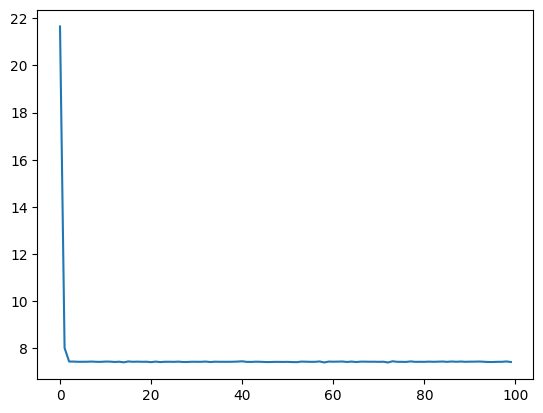

In [51]:
plt.plot(history)

In [52]:
# train MSE
yhat_b = model(X_3b)
MSE = torch.mean((y-yhat_b)**2)
print(MSE)

tensor(7.3834, grad_fn=<MeanBackward0>)


(c)

In [55]:
# R-squared 계산 함수 정의
def R2(y, yhat):
  SSE = torch.sum((y-yhat)**2)
  SST = torch.sum((y-torch.mean(y))**2)
  return 1 - SSE/SST

In [56]:
# (a)의 R2
R2(y,yhat_a)

tensor(0.3708, grad_fn=<RsubBackward1>)

In [57]:
# (b)의 R2
R2(y,yhat_b)

tensor(0.0719, grad_fn=<RsubBackward1>)

(d)

> model A

In [109]:
dataset = TensorDataset(X_3a,y)

n = len(y)

train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])

trainloader = DataLoader( dataset = train_set, batch_size = 5, shuffle = True)
testloader =  DataLoader( dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [110]:
model = torch.nn.Linear(3,1,bias=True)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yy, yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(y))

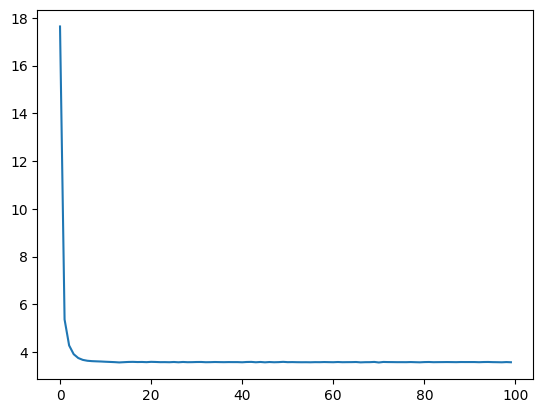

In [60]:
plt.plot(history)

MSE 구하기

In [65]:
# X_train (train set의 X)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train X들이 들어있는 list가 된다.)
X_train = torch.tensor(temp2).reshape(-1,3) # tensor로 변경하고 [n,3] shape으로 변경한다.

# y_train (train set의 y)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train Y들이 들어있는 list가 된다.)
y_train = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [66]:
X_train[:5]

tensor([[ 1.1088,  0.0000,  1.0000],
        [ 0.5066,  1.0000,  0.0000],
        [ 2.7650,  0.0000,  1.0000],
        [-0.6978,  1.0000,  0.0000],
        [ 1.4100,  0.0000,  1.0000]])

In [67]:
y_train[:5]

tensor([[ 8.6700],
        [10.0800],
        [ 8.7500],
        [ 7.2200],
        [10.0100]])

In [69]:
# train MSE
yhat = model(X_train)
MSE = torch.mean((y_train-yhat)**2)
print(MSE)

tensor(5.0751, grad_fn=<MeanBackward0>)


In [111]:
# test MSE
for X_test, y_test in testloader:
  yhat = model(X_test)
  ytest = y_test

MSE = torch.mean((ytest-yhat)**2)
print(MSE)

tensor(4.6170, grad_fn=<MeanBackward0>)


> model B

In [112]:
dataset = TensorDataset(X_3b,y)

n = len(y)

train_set, val_set = torch.utils.data.random_split(dataset, [int(np.floor(n*0.7)), n-int(np.floor(n*0.7))])

trainloader = DataLoader( dataset = train_set, batch_size = 5, shuffle = True)
testloader =  DataLoader( dataset = val_set, batch_size = n-int(np.floor(n*0.7)), shuffle = True)

In [113]:
model = torch.nn.Linear(1,1,bias=True)

epochs = 100
history = []

my_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    yhat = model(xx)
    loss = loss_ftn(yy, yhat)
    LOSS_sum += loss * len(yy)
    loss.backward()
    my_optimizer.step()
    my_optimizer.zero_grad()
  history.append(LOSS_sum.data/len(y))

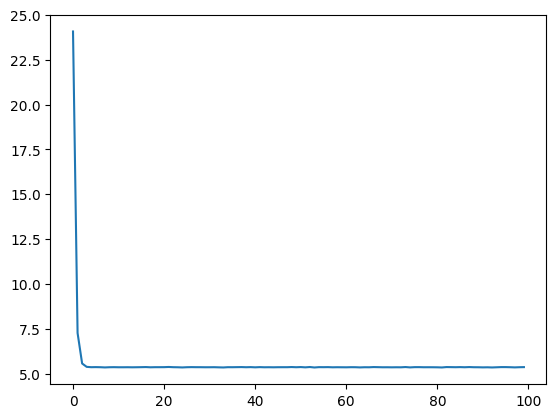

In [114]:
plt.plot(history)

MSE 구하기

In [116]:
# X_train (train set의 X)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = xx.tolist() # tensor인 x를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train X들이 들어있는 list가 된다.)
X_train = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

# y_train (train set의 y)
temp2 = []
for xx, yy in train_set: # train_set에 들어있는 x와 y 추출
  temp = yy.tolist() # tensor인 y를 list로 바꾼 후
  temp2 += temp # 더하여 list를 합쳐준다. (temp2는 train Y들이 들어있는 list가 된다.)
y_train = torch.tensor(temp2).reshape(-1,1) # tensor로 변경하고 [n,1] shape으로 변경한다.

In [117]:
X_train[:5]

tensor([[ 1.1088],
        [-0.6978],
        [-0.9989],
        [ 2.7650],
        [-0.9989]])

In [118]:
y_train[:5]

tensor([[ 8.6700],
        [ 7.2200],
        [10.6100],
        [ 8.7500],
        [10.4800]])

In [119]:
# train MSE
yhat = model(X_train)
MSE = torch.mean((y_train-yhat)**2)
print(MSE)

tensor(7.6068, grad_fn=<MeanBackward0>)


In [120]:
# test MSE
for X_test, y_test in testloader:
  yhat = model(X_test)
  ytest = y_test

MSE = torch.mean((ytest-yhat)**2)
print(MSE)

tensor(6.8654, grad_fn=<MeanBackward0>)
